**Package Installs And Imports**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import tensorflow as tf
# import tensorflow_addons as tfa
import PIL
import PIL.Image
from random import randint

In [ ]:
# print(tf.__version__)
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# !pip install py7zr

# import py7zr

# with py7zr.SevenZipFile("model.7z", mode="r") as archive:
#     archive.extractall("model")  # โฟลเดอร์ปลายทาง

print(os.listdir())  # แสดงไฟล์ทั้งหมดในโฟลเดอร์ปัจจุบัน

['.config', 'data', '.ipynb_checkpoints', 'model', 'model.7z', 'sample_data']


In [ ]:
PATH = "data/train"
file_types = ('*.jpg', '*.jpeg', '*.png')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

dataset = tf.keras.preprocessing.image_dataset_from_directory(PATH,
                                      shuffle=True,
                                      label_mode='categorical',
                                      batch_size=BATCH_SIZE,
                                      image_size=IMG_SIZE)

Found 2323 files belonging to 11 classes.


**Classes**

In [ ]:
class_names = dataset.class_names
num_classes = len(class_names)
print(num_classes)
print(class_names)

11
['Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Ct', 'Cu', 'Ns', 'Sc', 'St']


**Samples From Dataset**

*   Image
*   Class

**Prepare Train/Validation/Test Datasets**

In [ ]:
# Defining a function for the train, validation, and test split.

def get_dataset_partitions_tf(ds, ds_size, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds

In [ ]:
# Split the dataset into train, validation and test sets.
# Call the function get_dataset_partitions_pd

train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(dataset, ds_size=len(dataset))

print('Size of training dataset batch: %d' % len(train_dataset))
print('Size of validation dataset batch: %d' % len(validation_dataset))
print('Size of test dataset batch: %d' % len(test_dataset))

Size of training dataset batch: 51
Size of validation dataset batch: 14
Size of test dataset batch: 8


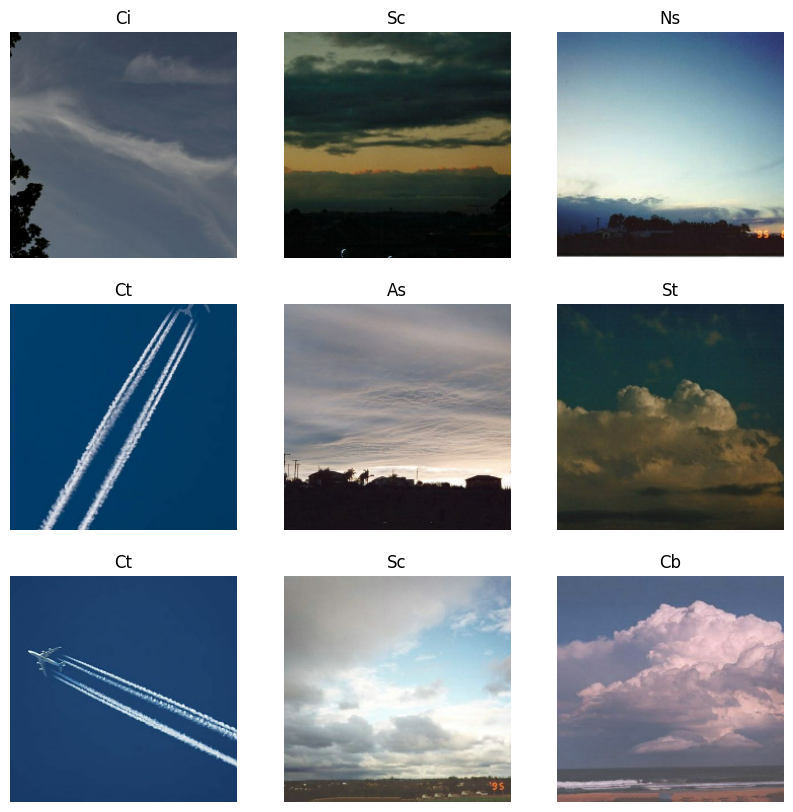

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
 for i in range(9):
   ax = plt.subplot(3, 3, i + 1)
   plt.imshow(images[i].numpy().astype("uint8"))
   plt.title(class_names[tf.argmax(labels[i]).numpy()])
   plt.axis("off")

**Setting Prefetch**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

**Data Augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(0.2)
])

**Samples From Data Augmentation**

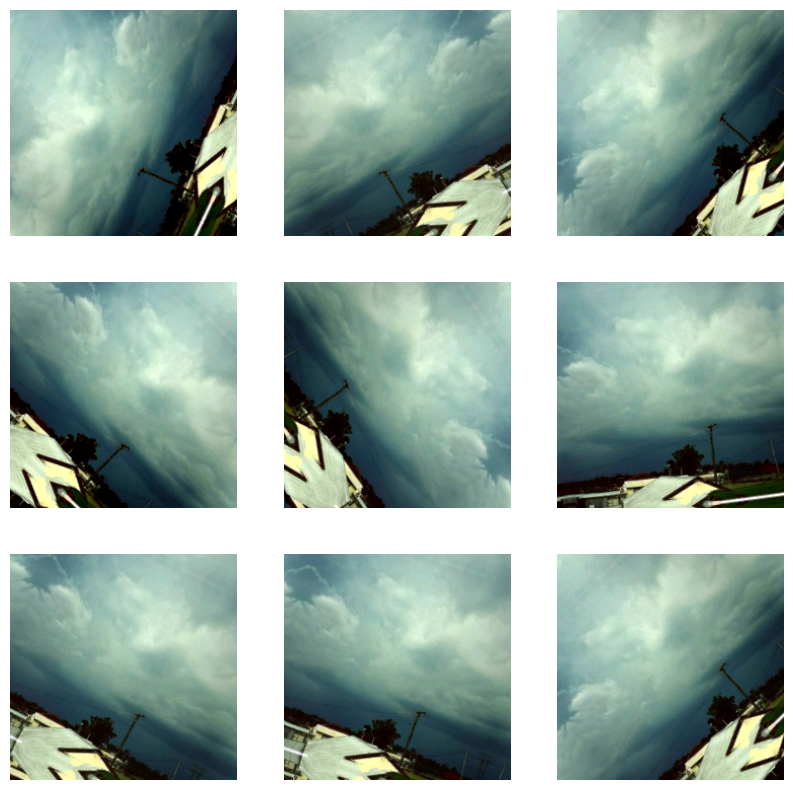

In [ ]:
for image, _ in train_dataset.take(1):
 plt.figure(figsize=(10, 10))
 first_image = image[0]
 for i in range(9):
   ax = plt.subplot(3, 3, i + 1)
   augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
   plt.imshow(augmented_image[0] / 255)
   plt.axis('off')

**Fetching ConvNextSmall Pre-Trained Model**

In [ ]:
# Create the base model from the pre-trained model EfficientNetV2L
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.DenseNet121(
  include_top=False,
  weights='imagenet',
  input_shape=IMG_SHAPE
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Shapes Of Features Extracted**

In [ ]:
image_batch, label_batch = train_dataset.as_numpy_iterator().next()
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1024)


**Trainable Variables**

In [ ]:
base_model.trainable = True

In [ ]:
len(base_model.trainable_variables)

362

**Freezeout Fine Tuning**

In [ ]:
# Let's take a look to see how many layers are in the base model
base_layer_count = len(base_model.layers)
print("Number of layers in the base model: ", base_layer_count)

# Fine-tune from this layer onwards
fine_tune_at = int(base_layer_count * (1 / 3))

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  427


In [ ]:
len(base_model.trainable_variables)

243

**Base Model Summary**

In [ ]:
base_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 5,523,712 (21.07 MB)

 Non-trainable params: 1,513,792 (5.77 MB)

**Pooling Layer**

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


**Prediction Layer**

In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 11)


**Building The Main Model Layers**

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

**Compiling The Main Model**

Includes evaluation metrics

In [ ]:
def build_metrics(no_of_classes):
  metrics = []
  metrics.append('accuracy')
  for i in range(0, no_of_classes):
    metric_name = '{}{}'.format('precision', i)
    metrics.append(tf.keras.metrics.Precision(class_id=i, name=metric_name))

  for i in range(0, no_of_classes):
    metric_name = '{}{}'.format('recall', i)
    metrics.append(tf.keras.metrics.Recall(class_id=i, name=metric_name))

  metrics.append(tf.keras.metrics.AUC(curve='ROC', name='roc_auc', multi_label=True, num_labels=no_of_classes))
  for i in range(0, no_of_classes):
    metric_name = '{}{}'.format('f1_score', i)
    metrics.append(tf.keras.metrics.F1Score(name=metric_name, threshold=0.5))

  return metrics

In [ ]:
metrics = build_metrics(num_classes)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │          11,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,048,779 (26.89 MB)

 Trainable params: 5,534,987 (21.11 MB)

 Non-trainable params: 1,513,792 (5.77 MB)

**Check The Main Model's Accuracy Before Training**

In [ ]:
def get_precision_evaluation(history):
  precision = 0.0
  precision_begin = 2
  precision_end = precision_begin + num_classes
  for i in range(precision_begin, precision_end):
    precision += history[i]

  return precision / num_classes

def get_recall_evaluation(history):
  recall = 0.0
  recall_begin = 2 + num_classes
  recall_end = recall_begin + num_classes
  for i in range(recall_begin, recall_end):
    recall += history[i]

  return recall / num_classes

def get_f1_score(precision, recall):
  f1_score = 0.0
  if (precision + recall) != 0:
    f1_score = (2 * precision * recall) / (precision + recall)

  return f1_score

In [ ]:
initial_history = model.evaluate(validation_dataset)

initial_precision = get_precision_evaluation(initial_history)
initial_recall = get_recall_evaluation(initial_history)
initial_f1_score = get_f1_score(initial_precision, initial_recall)
initial_roc_auc_index = 2 + (2 * num_classes)

print("Initial loss: {:.2f}".format(initial_history[0]))
print("Initial accuracy: {:.2f}".format(initial_history[1]))
print("Initial precision: {:.2f}".format(initial_precision))
print("Initial recall: {:.2f}".format(initial_recall))
print("Initial F1 score: {:.2f}".format(initial_f1_score))
print("Initial ROC: {:.2f}".format(initial_history[initial_roc_auc_index]))

14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 171ms/step - accuracy: 0.0424 - f1_score0: 0.0209 - f1_score1: 0.0209 - f1_score10: 0.0209 - f1_score2: 0.0209 - f1_score3: 0.0209 - f1_score4: 0.0209 - f1_score5: 0.0209 - f1_score6: 0.0209 - f1_score7: 0.0209 - f1_score8: 0.0209 - f1_score9: 0.0209 - loss: 15.2440 - precision0: 0.0000e+00 - precision1: 0.0000e+00 - precision10: 0.0000e+00 - precision2: 0.0000e+00 - precision3: 0.0000e+00 - precision4: 0.0000e+00 - precision5: 0.0000e+00 - precision6: 0.0333 - precision7: 0.0333 - precision8: 0.1816 - precision9: 0.0542 - recall0: 0.0000e+00 - recall1: 0.0000e+00 - recall10: 0.0000e+00 - recall2: 0.0000e+00 - recall3: 0.0000e+00 - recall4: 0.0000e+00 - recall5: 0.0000e+00 - recall6: 0.0077 - recall7: 0.3742 - recall8: 0.0589 - recall9: 0.0949 - roc_auc: 0.4548
Initial loss: 14.55
Initial accuracy: 0.06
Initial precision: 0.05
Initial recall: 0.06
Initial F1 score: 0.05
Initial ROC: 0.47


**Load Weights Or Train The Main Model**

If weights are saved, load them from Google Drive. If not, then train the main model.

**Load Weights**

In [1]:
model.load_weights('model/densenet_cloud_classification.weight.h5')

**Train The Main Model**

In [ ]:
initial_epochs = 100

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 482ms/step - accuracy: 0.2036 - f1_score0: 0.0637 - f1_score1: 0.0637 - f1_score10: 0.0637 - f1_score2: 0.0637 - f1_score3: 0.0637 - f1_score4: 0.0637 - f1_score5: 0.0637 - f1_score6: 0.0637 - f1_score7: 0.0637 - f1_score8: 0.0637 - f1_score9: 0.0637 - loss: 2.5051 - precision0: 0.0637 - precision1: 0.2522 - precision10: 0.0089 - precision2: 0.4457 - precision3: 0.3161 - precision4: 0.0000e+00 - precision5: 0.4789 - precision6: 0.5810 - precision7: 0.1360 - precision8: 0.1946 - precision9: 0.2825 - recall0: 0.0146 - recall1: 0.0289 - recall10: 7.6988e-04 - recall2: 0.0461 - recall3: 0.0889 - recall4: 0.0000e+00 - recall5: 0.0163 - recall6: 0.1116 - recall7: 0.0067 - recall8: 0.0307 - recall9: 0.0850 - roc_auc: 0.6072 - val_accuracy: 0.2589 - val_f1_score0: 0.1165 - val_f1_score1: 0.1165 - val_f1_score10: 0.1165 - val_f1_score2: 0.1165 - val_f1_score3: 0.1165 - val_f1_score4: 0.1165 - val_f1_score5: 0.1165 - val_f1_score6: 0.1165 - val_f1_score

**Save Weights**

If training is done, then save the weights to Google Drive.

In [ ]:
model.save_weights('model/densenet_cloud_classification.weights.h5')

In [ ]:
model.save('model/densenet_cloud_classification.h5')
model.save('model/densenet_cloud_classification.keras')

**Prepare Evaluation Metrics History Of Training**

In [ ]:
def get_precision_histories(history):
  precision_history = [0] * initial_epochs
  val_precision_history = [0] * initial_epochs
  for i in range(0, num_classes):
    metric_name = '{}{}'.format('precision', i)
    val_metric_name = 'val_' + metric_name
    precision_history = [sum(x) for x in zip(precision_history, history.history[metric_name])]
    val_precision_history = [sum(x) for x in zip(precision_history, history.history[val_metric_name])]

  for i in range(0, initial_epochs):
    precision_history[i] = precision_history[i] / num_classes
    val_precision_history[i] = val_precision_history[i] / num_classes

  return precision_history, val_precision_history

def get_recall_histories(history):
  recall_history = [0] * initial_epochs
  val_recall_history = [0] * initial_epochs
  for i in range(0, num_classes):
    metric_name = '{}{}'.format('recall', i)
    val_metric_name = 'val_' + metric_name
    recall_history = [sum(x) for x in zip(recall_history, history.history[metric_name])]
    val_recall_history = [sum(x) for x in zip(recall_history, history.history[val_metric_name])]

  for i in range(0, initial_epochs):
    recall_history[i] = recall_history[i] / num_classes
    val_recall_history[i] = val_recall_history[i] / num_classes

  return recall_history, val_recall_history

def calculate_f1_scores(precision, recall, val_precision, val_recall):
  f1_score_temp = np.empty(len(precision))
  val_f1_score_temp = np.empty(len(f1_score_temp))
  for i in range(len(precision)):
    harmonic_avg = 0.0
    if (precision[i] + recall[i]) != 0:
      harmonic_avg = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])

    val_harmonic_avg = 0.0
    if (val_precision[i] + val_recall [i]) != 0:
      val_harmonic_avg = (2 * val_precision[i] * val_recall [i]) / (val_precision[i] + val_recall [i])

    np.put(f1_score_temp, i, harmonic_avg)
    np.put(val_f1_score_temp, i, val_harmonic_avg)
  return [f1_score_temp, val_f1_score_temp]

In [ ]:
metric_name_loss = 'loss'
metric_name_accuracy = 'accuracy'

In [ ]:
acc = history.history[metric_name_accuracy]
val_acc = history.history['val_' + metric_name_accuracy]

loss = history.history[metric_name_loss]
val_loss = history.history['val_' + metric_name_loss]

roc_auc = history.history['roc_auc']
val_roc_auc = history.history['val_roc_auc']

precision, val_precision = get_precision_histories(history)

recall, val_recall = get_recall_histories(history)

f1_score, val_f1_score = calculate_f1_scores(precision, recall, val_precision, val_recall)

**Learning Curves**

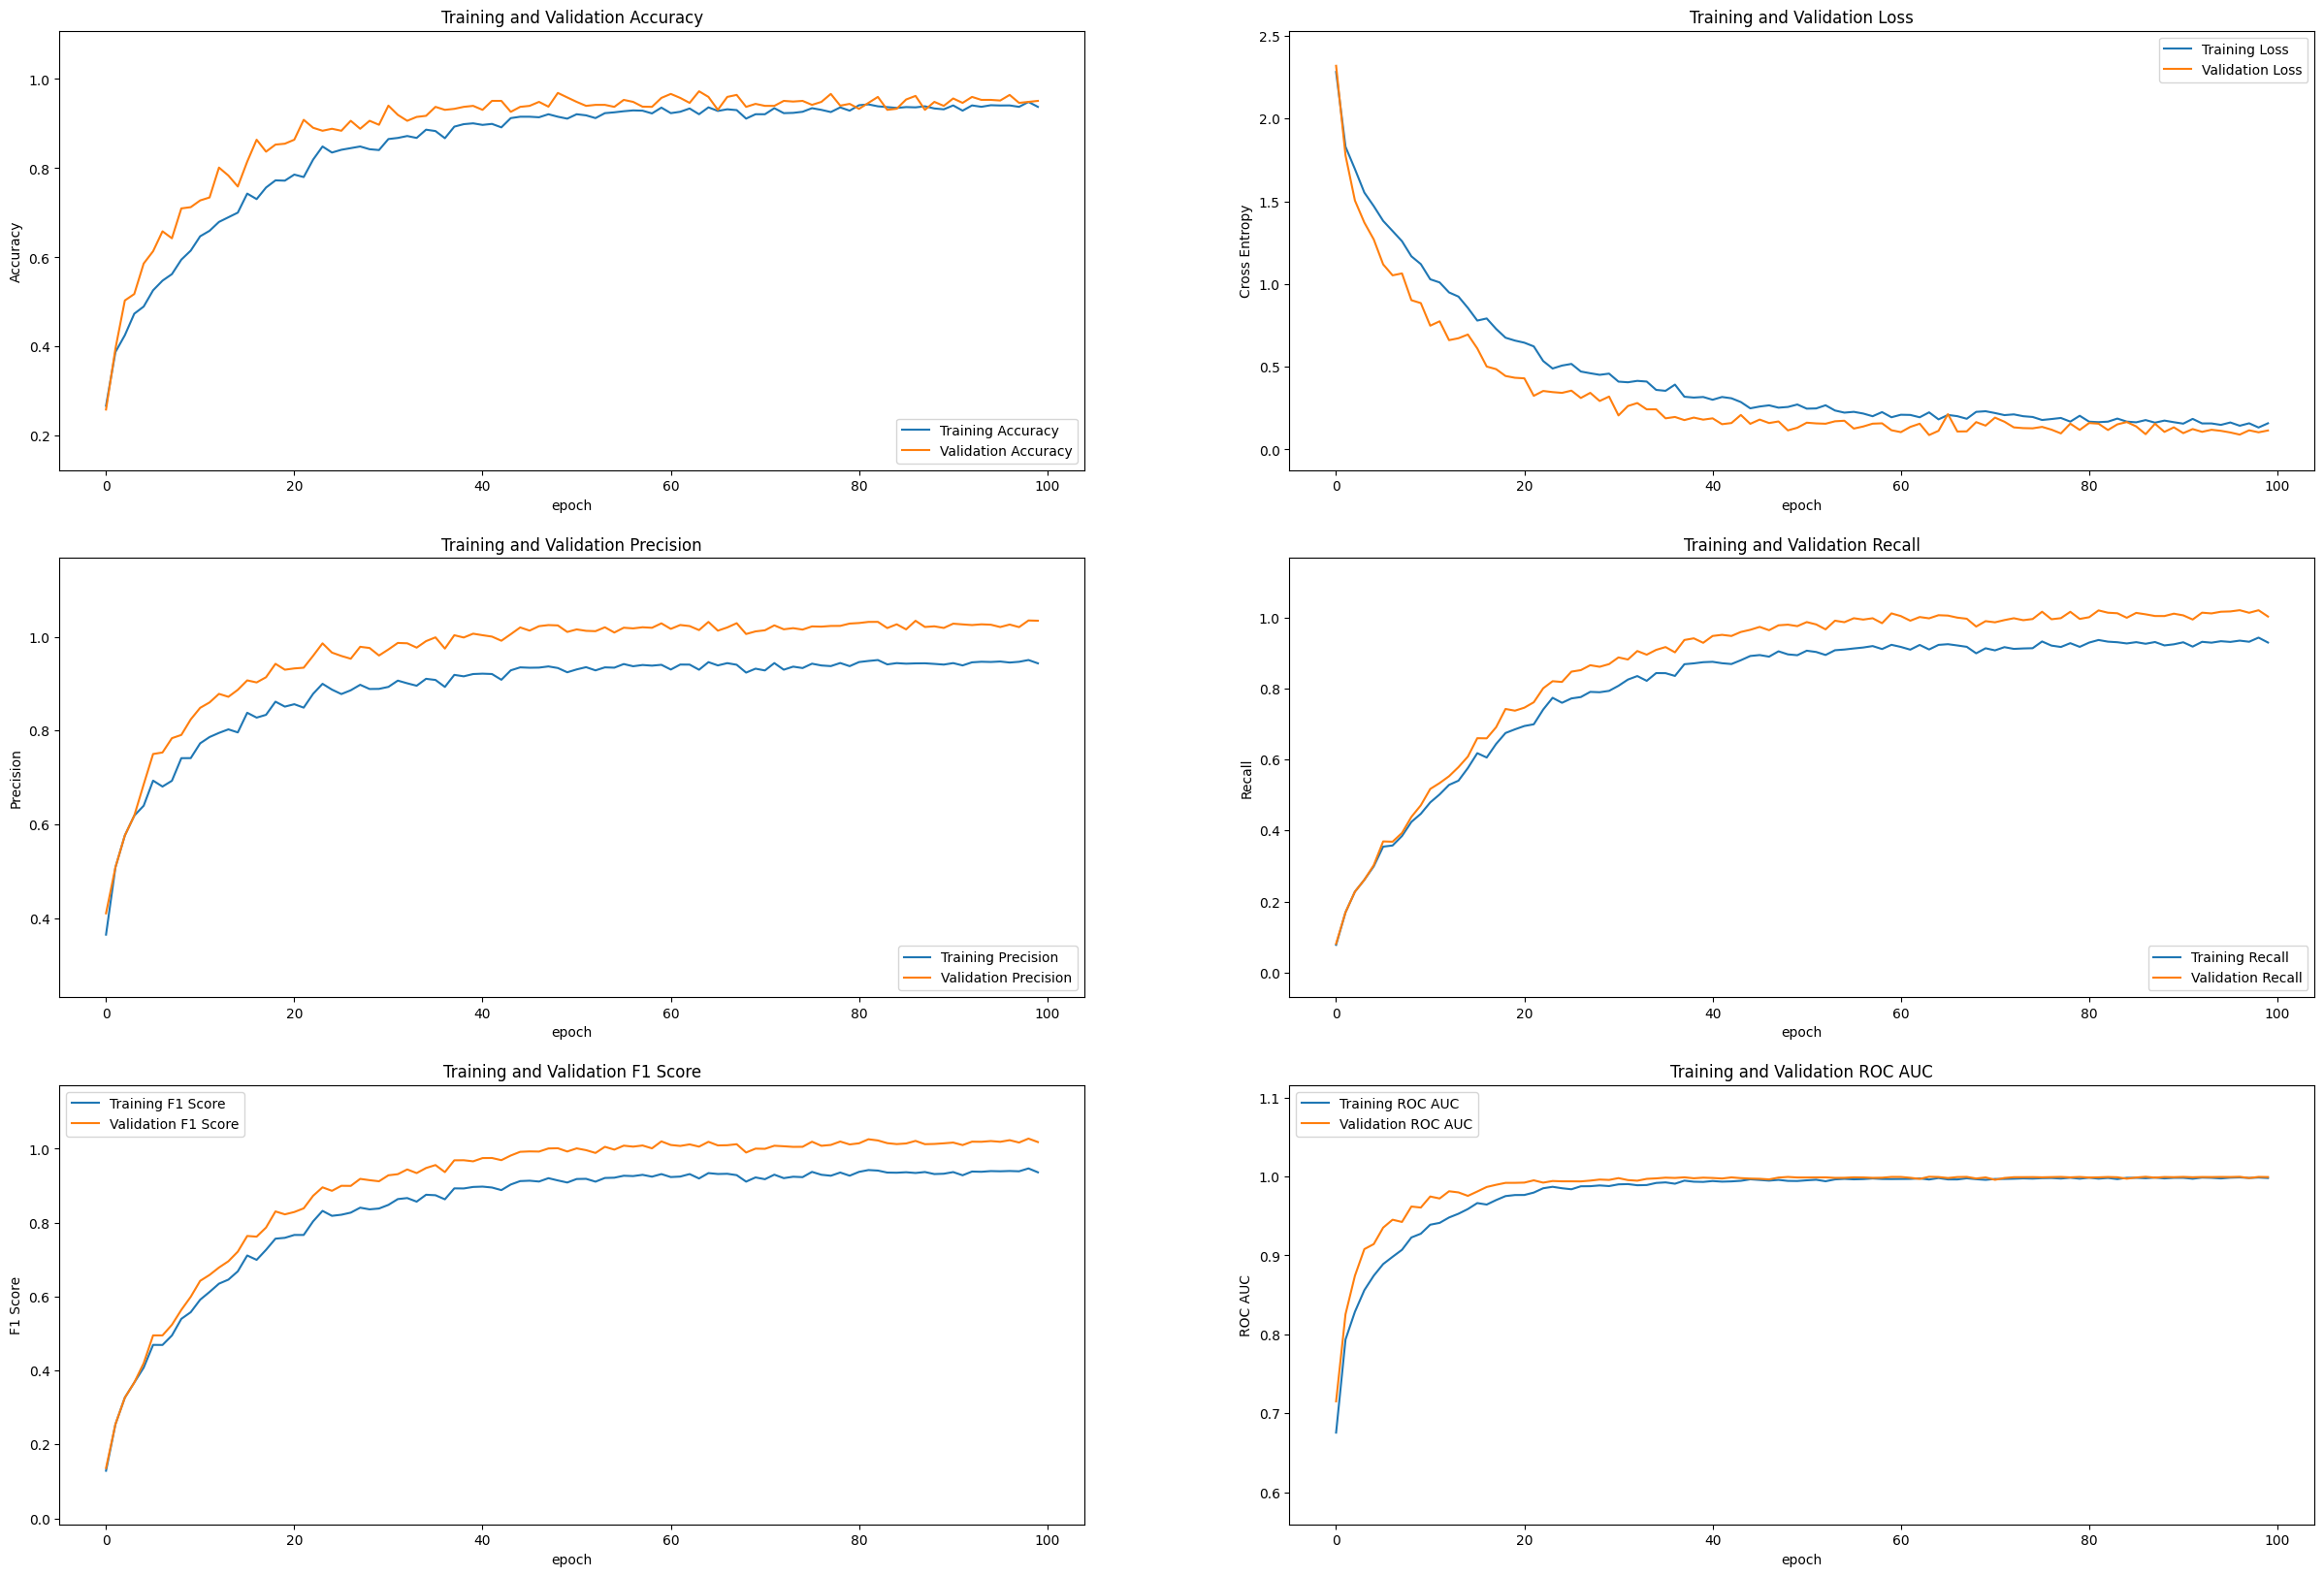

In [ ]:
plt.figure(figsize=(30, 20))

plt.subplot(3, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(3, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 2, 3)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')

plt.subplot(3, 2, 4)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Recall')
plt.xlabel('epoch')

plt.subplot(3, 2, 5)
plt.plot(f1_score, label='Training F1 Score')
plt.plot(val_f1_score, label='Validation F1 Score')
plt.legend(loc='upper left')
plt.ylabel('F1 Score')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation F1 Score')
plt.xlabel('epoch')

plt.subplot(3, 2, 6)
plt.plot(roc_auc, label='Training ROC AUC')
plt.plot(val_roc_auc, label='Validation ROC AUC')
plt.legend(loc='upper left')
plt.ylabel('ROC AUC')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation ROC AUC')
plt.xlabel('epoch')

plt.show()

**Final Evaluation Of The Trained Model Against Test Dataset**

In [ ]:
test_results = model.evaluate(test_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.9508 - f1_score0: 0.9526 - f1_score1: 0.9526 - f1_score10: 0.9526 - f1_score2: 0.9526 - f1_score3: 0.9526 - f1_score4: 0.9526 - f1_score5: 0.9526 - f1_score6: 0.9526 - f1_score7: 0.9526 - f1_score8: 0.9526 - f1_score9: 0.9526 - loss: 0.0915 - precision0: 0.9669 - precision1: 0.9550 - precision10: 1.0000 - precision2: 1.0000 - precision3: 0.9811 - precision4: 1.0000 - precision5: 0.9682 - precision6: 1.0000 - precision7: 0.9372 - precision8: 0.9372 - precision9: 0.8349 - recall0: 0.9739 - recall1: 0.9217 - recall10: 0.8645 - recall2: 0.9463 - recall3: 0.9664 - recall4: 1.0000 - recall5: 0.9835 - recall6: 1.0000 - recall7: 1.0000 - recall8: 0.9155 - recall9: 0.8568 - roc_auc: 0.9995


In [ ]:
test_precision = get_precision_evaluation(test_results)
test_recall = get_recall_evaluation(test_results)
test_f1_score = get_f1_score(test_precision, test_recall)
test_roc_auc_index = 2 + (2 * num_classes)

print("Test loss: {}".format(test_results[0]))
print("Test accuracy: {}".format(test_results[1]))
print("Test precision: {}".format(test_precision))
print("Test recall: {}".format(test_recall))
print("Test F1 score: {}".format(test_f1_score))
print("Test ROC: {}".format(test_results[test_roc_auc_index]))

Test loss: 0.11081884801387787
Test accuracy: 0.9423868060112
Test precision: 0.9605514407157898
Test recall: 0.9420042363080111
Test F1 score: 0.9511874341165131
Test ROC: 0.9992927312850952


**Multi-Class Confusion Matrices**

In [ ]:
images_test = []
labels_test = []

for batch in test_dataset:
  image_batch, label_batch = batch
  for i in image_batch:
    images_test.append(i)

  for i in label_batch:
    labels_test.append(i)

images_test = np.array(images_test)
labels_test = np.array(labels_test)
predictions = model.predict_on_batch(images_test)

In [ ]:
def get_highest_label(label_arr):
  max_num = -1
  max_index = -1
  for i in range(0, num_classes):
    if label_arr[i] > max_num:
      max_num = label_arr[i]
      max_index = i

  return max_index

In [ ]:
labelMapFunc = lambda x: get_highest_label(x)
labels_test_single = np.array([labelMapFunc(xi) for xi in labels_test])
predictions_test_single = np.array([labelMapFunc(xi) for xi in predictions])

In [ ]:
labels_test_single

array([ 3,  7,  3,  9, 10,  5,  4,  0,  6,  0,  1,  5,  9,  4,  6,  9,  8,
        7,  1,  6,  0,  0,  3,  9,  0,  3,  6,  2,  5,  2,  9,  3,  3,  2,
        0,  8,  7,  2,  8,  6,  8,  3,  9,  9,  8,  3,  5, 10,  0,  1,  3,
        7,  9, 10,  9, 10,  8,  1,  8, 10,  9,  7, 10,  0,  8,  1, 10,  9,
        8,  8,  9,  3, 10,  9,  3, 10, 10,  2,  2,  5,  2,  9,  4,  5,  9,
        9,  8,  7, 10,  5,  3,  2,  5,  4,  1,  9,  5,  9,  3,  0,  1,  3,
        0,  5,  2,  0,  2,  7,  9,  2,  3,  9,  7,  9,  2,  1,  9,  5,  0,
        9,  2,  3,  6,  9, 10,  9,  1,  9,  9,  7,  2,  6,  2,  9,  4,  5,
        7,  9,  4,  9,  0,  8,  3,  4,  9,  6,  5,  9,  7,  3,  7,  5,  5,
        9,  7,  9,  2,  3,  1,  1,  9,  1,  9,  7,  6,  6, 10,  9, 10,  5,
        7,  6,  1,  9,  6,  8, 10,  5,  1,  6,  6,  5,  1,  5,  7,  5,  5,
        4,  2,  0,  8,  2,  9, 10,  6,  5,  5, 10,  2,  3,  1,  8,  6,  2,
        7,  9, 10,  8,  7,  2,  3,  2,  1,  9,  7, 10,  0,  8,  8,  1,  6,
        0,  6,  8,  6,  5

In [ ]:
predictions_test_single

array([ 3,  7,  3,  9, 10,  3,  4,  0,  6,  0,  1,  5,  9,  4,  6,  8,  8,
        7,  1,  6,  0,  1,  3,  9,  0,  3,  6,  2,  5,  2,  9,  3,  3,  2,
        0,  8,  7,  2,  8,  6,  8,  3,  9,  8,  8,  3,  5, 10,  0,  1,  3,
        7,  9, 10,  9, 10,  8,  1,  8, 10,  9,  4, 10,  0,  8,  1, 10,  9,
        8,  8,  9,  3, 10,  9,  3, 10, 10,  2,  2,  5,  2,  9,  4,  5,  9,
        9,  8,  7, 10,  5,  3,  2,  5,  4,  1,  9,  5,  9,  3,  0,  1,  3,
        0,  5,  2,  0,  2,  7,  9,  2,  3,  9,  7,  9,  2,  1,  9,  5,  0,
        9,  2,  3,  6,  9, 10,  9,  1,  9,  9,  7,  2,  6,  2,  9,  4,  5,
        7,  9,  4,  9,  0,  8,  3,  4,  9,  6,  5,  9,  7,  3,  7,  5,  5,
        9,  7,  9,  2,  0,  0,  1,  9,  1,  9,  7,  6,  6, 10,  9, 10,  5,
        7,  6,  1,  9,  6,  8,  7,  5,  1,  6,  6,  5,  1,  5,  7,  5,  5,
        4,  2,  3,  8,  2,  9, 10,  6,  5,  5, 10,  2,  3,  1,  8,  6,  2,
        7,  9, 10, 10,  7,  7,  3,  2,  1,  9,  7, 10,  0,  8,  8,  1,  6,
        0,  6,  8,  6,  5

In [ ]:
multi_class_confusion_matrix = []
for i in range(0, num_classes):
  row = [0] * num_classes
  multi_class_confusion_matrix.append(row)

for i in range(0, len(labels_test_single)):
  actual = labels_test_single[i]
  pred = predictions_test_single[i]

  multi_class_confusion_matrix[actual][pred] = multi_class_confusion_matrix[actual][pred] + 1

multi_class_confusion_matrix

[[19, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 23, 0, 0, 0, 0, 2, 0, 0, 0],
 [1, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 2, 0, 25, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 22, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 2, 40, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 21]]

In [ ]:
def print_matrix(matrix):
  s = ''
  for i in range(0, len(matrix)):
    for j in range(0, len(matrix[0])):
      s = s + '\t' + str(matrix[i][j])
    s = s + '\n'

  print(s)

In [ ]:
print_matrix(multi_class_confusion_matrix)

	19	0	0	0	0	0	0	0	0	0	0
	1	15	0	2	0	3	0	0	1	1	0
	0	0	18	0	1	2	1	0	1	0	0
	1	0	0	34	0	1	0	0	0	0	0
	0	0	0	3	15	1	0	0	0	0	0
	0	0	0	4	0	20	0	0	0	0	0
	0	0	0	0	0	0	17	0	0	0	0
	0	0	0	0	0	1	0	15	0	0	0
	0	0	0	0	0	0	0	0	26	2	2
	0	0	0	0	0	0	0	0	0	35	0
	0	0	0	0	0	0	0	0	1	0	13



**Samples From Predicted Test Dataset**

*   Image
*   Predicted class with its prediction probability
*   Actual Class

In [ ]:
print('test size: ', len(test_dataset))

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
print('image_batch size: ', len(image_batch))
print('label_batch size: ', len(label_batch))
print('label_batch example: ', label_batch[0])

predictions = model.predict_on_batch(image_batch)
print('predictions size: ', len(predictions))
print('predictions example: ', predictions[0])

test size:  8
image_batch size:  32
label_batch size:  32
label_batch example:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
predictions size:  32
predictions example:  [9.3347393e-07 6.1937189e-04 2.9507356e-03 1.8614216e-04 8.4201962e-04
 4.8858701e-06 1.8283672e-05 1.9173087e-06 9.9434161e-01 1.1515971e-05
 1.0225750e-03]


In [ ]:
def plot_image(i, predictions_array, true_label, img):
  img = img[i]
  true_label = true_label[i]
  true_label = np.argmax(true_label)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img.astype("uint8"))

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  true_label = np.argmax(true_label)
  plt.grid(False)
  plt.xticks(range(num_classes), class_names)
  plt.yticks([])
  thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
def generate_random_indices(max_number, size):
  result = []
  random_number = randint(0, max_number - 1)
  while len(result) < size:
    while random_number in result:
      random_number = randint(0, max_number - 1)

    result.append(random_number)

  return result

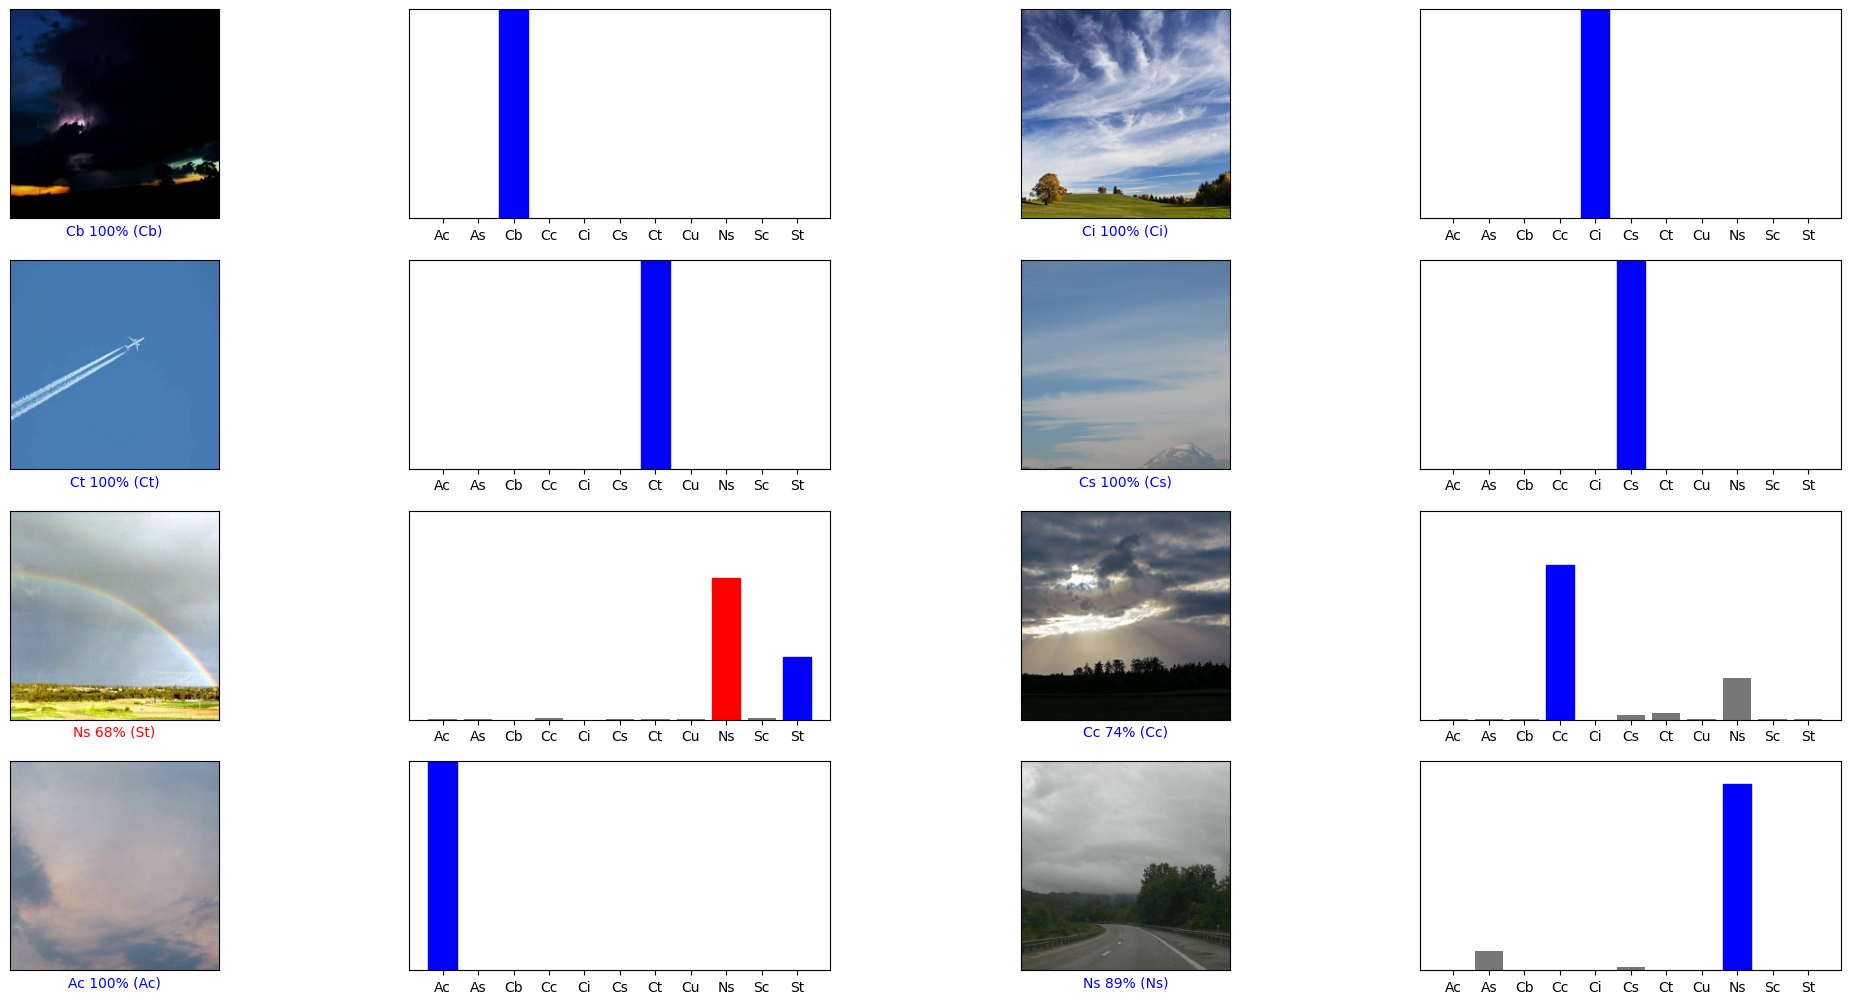

In [ ]:
row_count = 4
col_count = 2
img_view_size = row_count * col_count

indices = generate_random_indices(len(image_batch), img_view_size)

plt.figure(figsize=(12.5 * col_count, 3.12 * row_count))
for j in range(0, img_view_size):
  i = indices[j]

  #display image
  plt.subplot(row_count, 2 * col_count, 2 * j + 1)
  plot_image(i, predictions[i], label_batch, image_batch)

  #display prediction bar graph
  plt.subplot(row_count, 2 * col_count, (2 * j) + 2)
  plot_value_array(i, predictions[i],  label_batch)

plt.show()

In [ ]:
import glob

def predict_and_plot(image_path):
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  predicted_class = np.argmax(predictions[0])

  plt.figure(figsize=(6, 3))
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.title(f"Predicted: {class_names[predicted_class]}, Type: {image_path.split('/')[-1][:2]}")
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plot_value_array(0, predictions[0], [0] * num_classes)
  plt.show()

def predict_and_plot_all_images(folder_path):
  image_paths = glob.glob(os.path.join(folder_path, '*'))
  for image_path in image_paths:
    predict_and_plot(image_path)

predict_and_plot_all_images('../sample-test-data')